In [61]:
#Importing required packages
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [63]:
#Reading obtained centrality scores
c = pd.read_csv('centrality_scores.csv')
cols = c.drop(columns='name').columns.tolist()

In [65]:
#Data preprocessing
c_log = c.copy()
for col in cols:
    c_log[f"log_{col}"] = np.log1p(c[col])
X = c_log[['log_degree',
 'log_in_degree',
 'log_out_degree',
 'log_betweenness',
 'log_closeness',
 'log_eigenvector']].values

scaler = StandardScaler()
X_std = scaler.fit_transform(X)

asset = pd.read_csv('output_ml_students/backend_asset.csv',dtype={'name': object}) ### Asset file directory here ###
atype = pd.read_csv('output_ml_students/backend_assettype.csv') ### Asset type file directory here ###
c_meta = c_log.merge(asset[['id', 'asset_type_id','vlan_ids']], left_on='name', right_on = 'id', how='left')
atype.loc[56] = ['Unknown'] + 5*[0]+ ['Unknown']+4*[0]
c_meta = c_meta.merge(atype[['id', 'category']], left_on='asset_type_id', right_on='id', how='left')
c_meta = c_meta.drop(['id_x','id_y'],axis = 1)
c_meta = c_meta.fillna('Unknown')

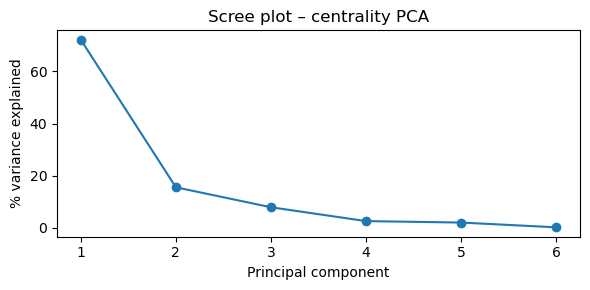

Cumulative variance  PC1: 72.2197191668317   PC1+PC2: 87.70424986783648


,PC1,PC2,PC3,PC4,PC5,PC6
degree,0.47,-0.03,-0.11,0.20,0.30,0.80
in_degree,0.46,-0.09,0.00,0.77,-0.15,-0.41
out_degree,0.46,0.03,-0.09,-0.38,0.66,-0.44
betweenness,0.43,-0.12,-0.54,-0.39,-0.60,-0.02
closeness,0.16,0.97,0.08,-0.01,-0.14,0.01
eigenvector,0.38,-0.17,0.82,-0.27,-0.27,0.05


In [67]:
#Principal Component Analysis (PCA)

pca = PCA().fit(X_std)

# Scree plot
plt.figure(figsize=(6,3))
plt.plot(np.arange(1, len(pca.explained_variance_ratio_)+1),
         pca.explained_variance_ratio_*100, marker='o')
plt.ylabel("% variance explained"); plt.xlabel("Principal component")
plt.title("Scree plot – centrality PCA")
plt.xticks(range(1,7))
plt.tight_layout();
plt.show()

print("Cumulative variance  PC1:", pca.explained_variance_ratio_[0]*100,
      "  PC1+PC2:", pca.explained_variance_ratio_[:2].sum()*100)

loadings = pd.DataFrame(
    pca.components_.T,
    index = cols,
    columns=[f'PC{i+1}' for i in range(len(cols))]
)
display(loadings.style.format("{:.2f}"))

scores = pca.transform(X_std)      # N × 6 matrix of PC scores
df_pca  = c_log[['name']].copy()
df_pca[['PC1','PC2']] = scores[:,:2]
df_pca = df_pca.merge(c_meta[['name','category']], on='name', how='left')

In [69]:
#ALE value allocation
df_pca_rank = df_pca.sort_values('PC1', ascending=False)
df_pca_rank['PC1'] = df_pca_rank['PC1'] - min(df_pca_rank['PC1'])
df_pca_rank['PC2'] = df_pca_rank['PC2'] - min(df_pca_rank['PC2'])

df_pca_rank['Comp_score'] = pca.explained_variance_ratio_[0]*df_pca_rank['PC1'] + pca.explained_variance_ratio_[1]*df_pca_rank['PC2']

budget = 5_000_000
total_pos = df_pca_rank['Comp_score'].sum()

scaling_factor = budget / total_pos if total_pos else 0

df_pca_rank['value_eur'] = (df_pca_rank['Comp_score'] * scaling_factor).round(2)

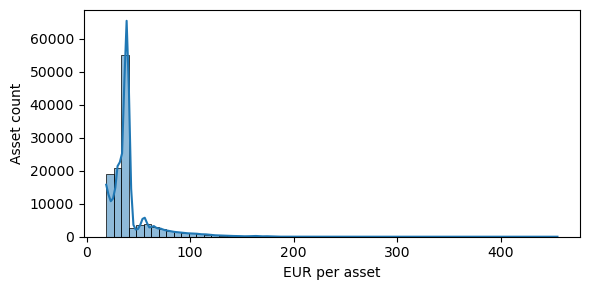

,total_eur,mean_eur,n_assets,share_%
category,,,,
Network,3116871.55,45.83,68008,62.3
Unknown,1815984.88,35.93,50546,36.3
IT,38284.08,146.12,262,0.8
Other,23086.36,120.24,192,0.5
OT,2842.66,54.67,52,0.1
IoT,2790.47,84.56,33,0.1


          N_assets  Total_EUR  Mean_EUR  Share_%
category                                        
IT              72   21304.15    295.89     72.0
Other           23    6087.61    264.68     23.0
Network          4    1004.99    251.25      4.0
IoT              1     227.74    227.74      1.0


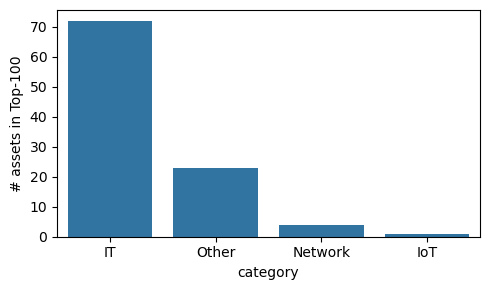

In [71]:
#ALE value analysis
df_pca_sorted = df_pca_rank.sort_values('value_eur', ascending=False)
plt.figure(figsize=(6,3))
sns.histplot(df_pca_sorted['value_eur'],
             bins=60,
             kde=True)
plt.xlabel('EUR per asset')
plt.ylabel('Asset count')
plt.tight_layout()
plt.show()

cat_totals = (
    df_pca_rank.groupby('category')['value_eur']
      .agg(total_eur='sum', mean_eur='mean', n_assets='count')
      .sort_values('total_eur', ascending=False)
)

cat_totals['share_%'] = (cat_totals['total_eur'] /
                         cat_totals['total_eur'].sum() * 100).round(1)

display(cat_totals.round(2))

top100 = df_pca_sorted.nlargest(100, 'value_eur').copy()

cat_summary = (
    top100.groupby('category')
          .agg(N_assets   = ('name', 'count'),
               Total_EUR  = ('value_eur', 'sum'))
          .sort_values('N_assets', ascending=False)
)
cat_summary['Mean_EUR'] = cat_summary['Total_EUR'] / cat_summary['N_assets']
cat_summary['Share_%']  = cat_summary['N_assets'] / 100 * 100
print(cat_summary.round(2))

plt.figure(figsize=(5,3))
sns.barplot(x=cat_summary.index,
            y=cat_summary['N_assets'])
plt.ylabel('# assets in Top-100')
plt.tight_layout();
plt.show()

WHAT FOLLOWS IS THE CODE FOR THE ANALYSIS PERFORMED IN THE THESIS.
THE FOLLOWING CODE IS NOT DIRECTLY CONNECTED TO ALE ESTIMATIONS.

,min,q1,median,q3,99th percentile,max,mean
metric,,,,,,,
degree,1.0,2.000000,2.000000,2.000000,78.000000,7.628000e+04,9.777670
in_degree,0.0,1.000000,1.000000,1.000000,40.000000,3.740800e+04,4.888835
out_degree,0.0,1.000000,1.000000,1.000000,39.000000,3.887200e+04,4.888835
betweenness,0.0,0.000000,0.000000,0.000000,315739.531800,4.347233e+09,122146.244548
closeness,0.0,0.089996,0.170611,0.216509,0.216509,3.248795e-01,0.142355
eigenvector,0.0,0.000000,0.000047,0.000285,0.011629,1.583370e-01,0.000627


,min,q1,median,q3,max,mean
metric,,,,,,
log_degree,0.693147,1.098612,1.098612,1.098612,11.242179,1.297637
log_in_degree,0.000000,0.693147,0.693147,0.693147,10.529667,0.856857
log_out_degree,0.000000,0.693147,0.693147,0.693147,10.568055,0.865515
log_betweenness,0.000000,0.000000,0.000000,0.000000,22.192805,1.650271
log_closeness,0.000000,0.086174,0.157526,0.195985,0.281321,0.130874
log_eigenvector,0.000000,0.000000,0.000047,0.000285,0.146985,0.000623


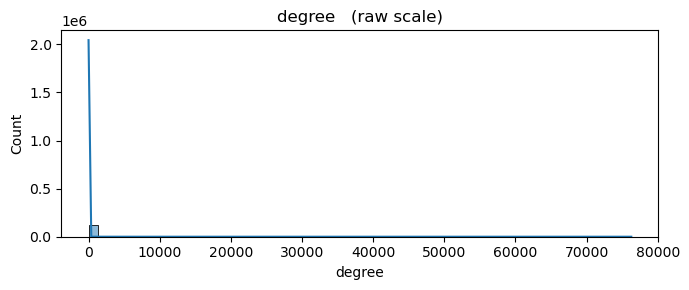

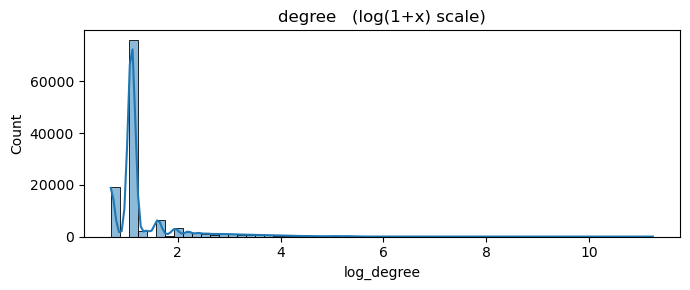

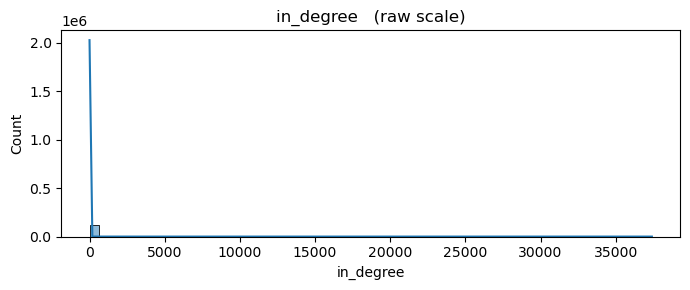

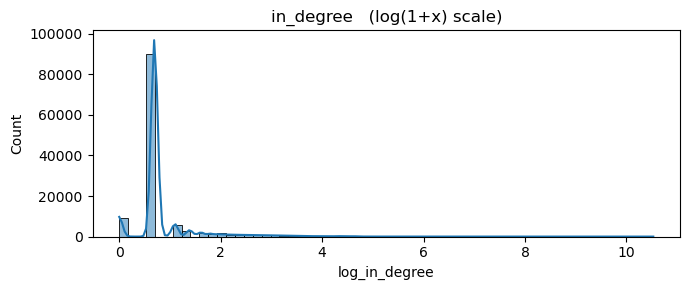

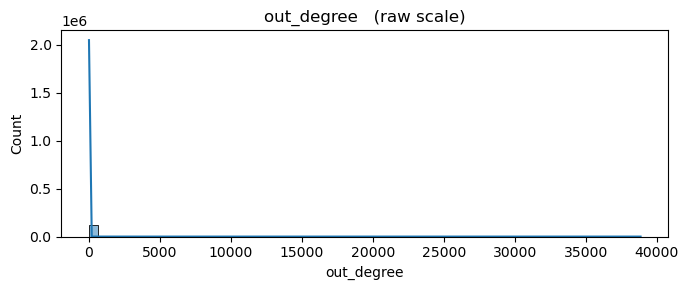

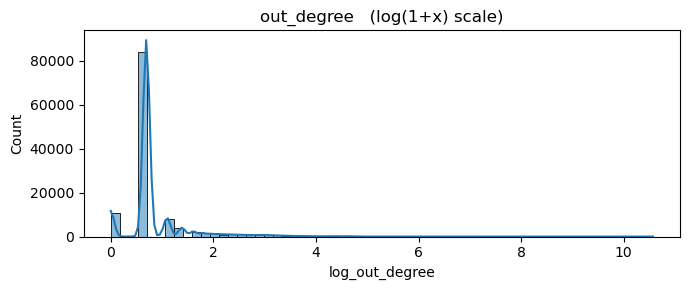

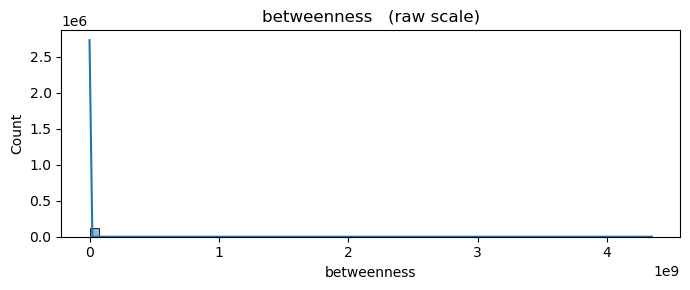

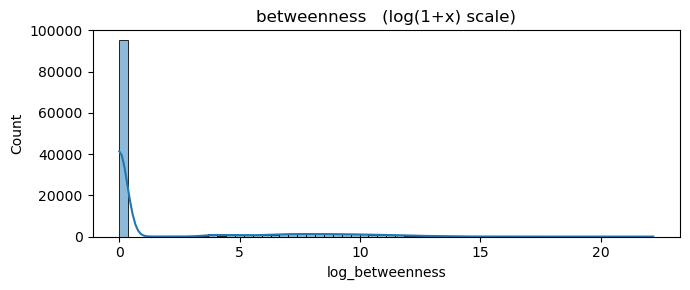

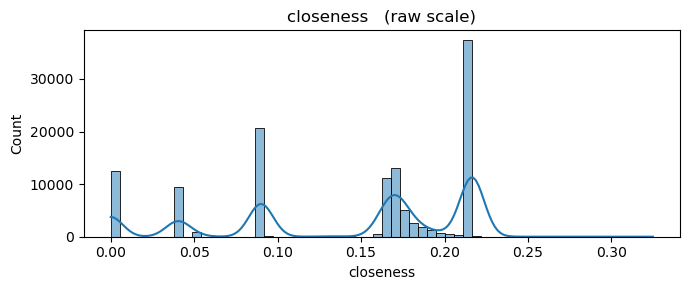

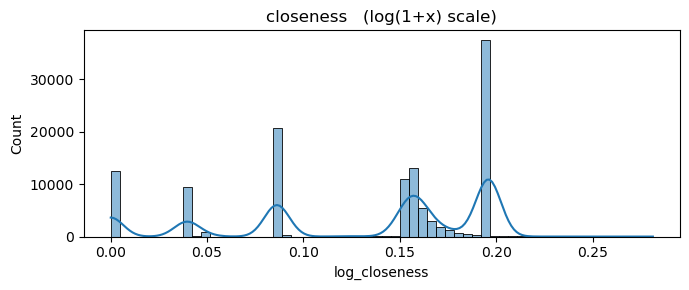

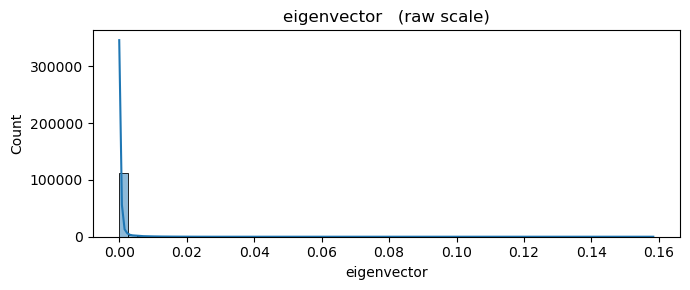

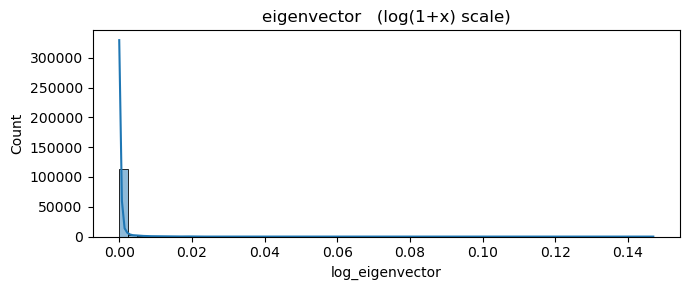

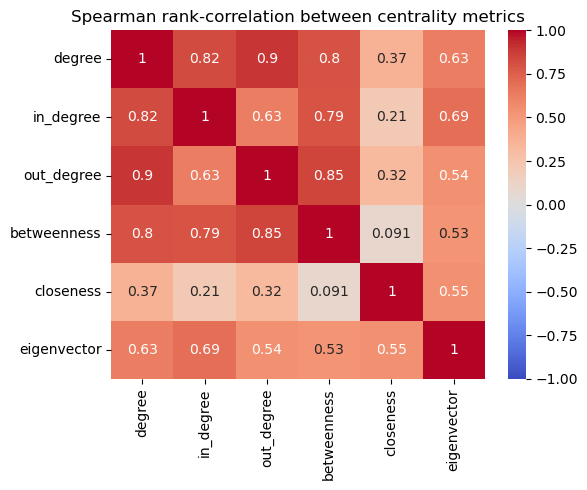

,name,degree,metric
182,a807012c-4456-4764-8e5a-4f52610429d5,76280,degree
151,48dcb782-a6f0-4863-b070-dac5deacb858,42276,degree
68,a551fc87-630f-4b89-8b43-4e89325c43cc,19072,degree
41,2793f9b1-baa0-49d0-84b9-85ecc32bbb4a,17529,degree
103,d84478e3-ec75-427a-a219-2053c49ef78e,15280,degree
2827,3521f0d3-3827-4876-ab23-fc8634ae3d40,11770,degree
2851,51235dd2-ab6e-493c-aeef-2ced33114883,11455,degree
94,8bf1fc05-b2aa-4bc9-90ab-0513e0af6ff1,10273,degree
11544,eda0a7d1-6a6f-48db-90da-578fc6ba55b8,9155,degree
2882,94d406f9-e09a-43dc-b565-e9edc67ba5a1,8917,degree


,name,in_degree,metric
182,a807012c-4456-4764-8e5a-4f52610429d5,37408.000000,in_degree
151,48dcb782-a6f0-4863-b070-dac5deacb858,20916.000000,in_degree
68,a551fc87-630f-4b89-8b43-4e89325c43cc,9517.000000,in_degree
41,2793f9b1-baa0-49d0-84b9-85ecc32bbb4a,8606.000000,in_degree
103,d84478e3-ec75-427a-a219-2053c49ef78e,7588.000000,in_degree
2827,3521f0d3-3827-4876-ab23-fc8634ae3d40,5865.000000,in_degree
2851,51235dd2-ab6e-493c-aeef-2ced33114883,5706.000000,in_degree
94,8bf1fc05-b2aa-4bc9-90ab-0513e0af6ff1,5084.000000,in_degree
11544,eda0a7d1-6a6f-48db-90da-578fc6ba55b8,4550.000000,in_degree
2882,94d406f9-e09a-43dc-b565-e9edc67ba5a1,4435.000000,in_degree


,name,out_degree,metric
182,a807012c-4456-4764-8e5a-4f52610429d5,38872.000000,out_degree
151,48dcb782-a6f0-4863-b070-dac5deacb858,21360.000000,out_degree
68,a551fc87-630f-4b89-8b43-4e89325c43cc,9555.000000,out_degree
41,2793f9b1-baa0-49d0-84b9-85ecc32bbb4a,8923.000000,out_degree
103,d84478e3-ec75-427a-a219-2053c49ef78e,7692.000000,out_degree
2827,3521f0d3-3827-4876-ab23-fc8634ae3d40,5905.000000,out_degree
2851,51235dd2-ab6e-493c-aeef-2ced33114883,5749.000000,out_degree
94,8bf1fc05-b2aa-4bc9-90ab-0513e0af6ff1,5189.000000,out_degree
11544,eda0a7d1-6a6f-48db-90da-578fc6ba55b8,4605.000000,out_degree
2882,94d406f9-e09a-43dc-b565-e9edc67ba5a1,4482.000000,out_degree


,name,betweenness,metric
182,a807012c-4456-4764-8e5a-4f52610429d5,4347233014.473551,betweenness
41,2793f9b1-baa0-49d0-84b9-85ecc32bbb4a,550355714.444849,betweenness
151,48dcb782-a6f0-4863-b070-dac5deacb858,505296255.490177,betweenness
103,d84478e3-ec75-427a-a219-2053c49ef78e,378422527.519970,betweenness
2827,3521f0d3-3827-4876-ab23-fc8634ae3d40,245841156.711878,betweenness
2851,51235dd2-ab6e-493c-aeef-2ced33114883,201189196.722629,betweenness
3021,7e20e6a8-3749-4517-afb1-f495d4cfab9e,194315059.997965,betweenness
11544,eda0a7d1-6a6f-48db-90da-578fc6ba55b8,162176757.444040,betweenness
2831,ca56e0f7-12a0-45be-a4e2-59930ec225af,155166963.949684,betweenness
94,8bf1fc05-b2aa-4bc9-90ab-0513e0af6ff1,149977780.690153,betweenness


,name,closeness,metric
182,a807012c-4456-4764-8e5a-4f52610429d5,0.324879,closeness
97,a5445053-6b28-450b-9e2d-886b0cb2e7b7,0.317011,closeness
657,96962d4f-08c9-4cf7-9f93-8b03e9461871,0.313326,closeness
718,8c3ce1f5-ad8d-4c0c-a716-2d5282504c24,0.313325,closeness
551,776ffffb-7565-4135-bfa6-3ec9a7cd1a64,0.313127,closeness
1869,6206b796-3094-4981-8eb7-3317623345da,0.313074,closeness
1063,5d881fde-a199-45c6-8391-7e1a50aa52bb,0.313057,closeness
111,0c8b3dcd-955a-49ee-8e18-86813dac8c46,0.312700,closeness
885,76330150-bc1e-4c18-8264-659f75161c92,0.312503,closeness
986,d0127b75-8569-4a40-8421-26d7b9510782,0.312489,closeness


,name,eigenvector,metric
103,d84478e3-ec75-427a-a219-2053c49ef78e,0.158337,eigenvector
41,2793f9b1-baa0-49d0-84b9-85ecc32bbb4a,0.156453,eigenvector
2851,51235dd2-ab6e-493c-aeef-2ced33114883,0.150485,eigenvector
2827,3521f0d3-3827-4876-ab23-fc8634ae3d40,0.147181,eigenvector
94,8bf1fc05-b2aa-4bc9-90ab-0513e0af6ff1,0.141092,eigenvector
2882,94d406f9-e09a-43dc-b565-e9edc67ba5a1,0.130191,eigenvector
11544,eda0a7d1-6a6f-48db-90da-578fc6ba55b8,0.129200,eigenvector
2837,7b48c746-0af0-4094-89a0-afefd463000a,0.126532,eigenvector
12706,f5fd482a-794e-4a5f-aac3-f2754d231380,0.125372,eigenvector
2836,13822517-d5e4-4f7d-8ea0-c93a536b6407,0.121601,eigenvector


{1: 227, 2: 155, 3: 94, 4: 82, 5: 42, 6: 0}


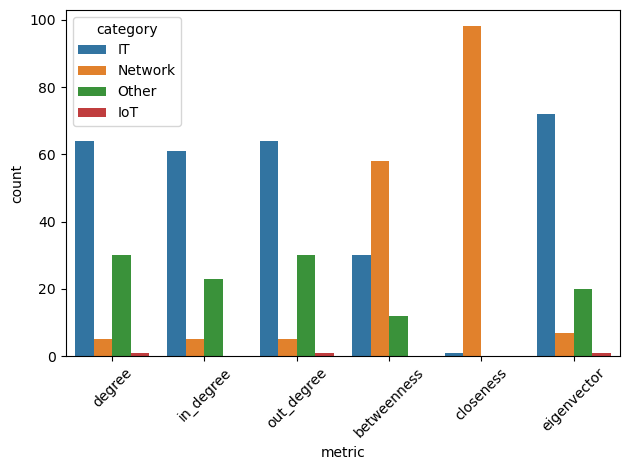

In [74]:
#Background analysis
summary = []
for col in metric_cols:
    s = c[col]
    summary.append({
        "metric"   : col,
        "min"      : s.min(),
        "q1"       : s.quantile(.25),
        "median"   : s.median(),
        "q3"       : s.quantile(.75),
        "99th percentile": s.quantile(0.99),
        "max"      : s.max(),
        "mean"     : s.mean(),
    })
    
summary_raw = pd.DataFrame(summary).set_index("metric")
display(summary_raw)

summary_log = []
for col in metric_cols:
    s = c_log[f"log_{col}"]
    summary_log.append({
        "metric"   : f"log_{col}",
        "min"      : s.min(),
        "q1"       : s.quantile(.25),
        "median"   : s.median(),
        "q3"       : s.quantile(.75),
        "max"      : s.max(),
        "mean"     : s.mean(),
    })

summary_log = pd.DataFrame(summary_log).set_index("metric")
display(summary_log)

for col in metric_cols:
    # raw
    plt.figure(figsize=(7,3))
    sns.histplot(c[col], bins=60, kde=True)
    plt.title(f"{col}   (raw scale)")
    plt.tight_layout();
    plt.show()
    
    # log
    plt.figure(figsize=(7,3))
    sns.histplot(c_log[f"log_{col}"], bins=60, kde=True)
    plt.title(f"{col}   (log(1+x) scale)")
    plt.tight_layout();
    plt.show()

corr_cols = ['degree', 'in_degree', 'out_degree', 'betweenness', 'closeness', 'eigenvector']
X = c_log[corr_cols] 

corr= X.corr(method='spearman')

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Spearman rank-correlation between centrality metrics")
plt.tight_layout()
plt.show()

top_n = 100
top_lists = {}
for col in cols:
    top_lists[col] = (
        c_log
        .nlargest(top_n, col)
        .loc[:, ['name', col]]
        .assign(metric=col)
    )

for col, tbl in top_lists.items():
    display(tbl.style.set_caption(f"Top {top_n} – {col}"))

sets = {metric: set(tbl['name']) for metric, tbl in top_lists.items()}

# how many nodes appear in *at least k* metrics?
intersection_counts = {}
for k in range(1, len(cols)+1):
    # nodes that appear in ≥ k sets
    nodes_k = set.intersection(*[s for s in sets.values()]) if k==len(sets) else \
              {n for n in set.union(*sets.values()) if sum(n in s for s in sets.values()) >= k}
    intersection_counts[k] = len(nodes_k)
    
print(intersection_counts)

top_master = pd.concat(top_lists.values(), ignore_index=True)
top_master = pd.concat(top_lists.values(), ignore_index=True)
top_master = top_master.melt(id_vars=['name', 'metric'],
                             value_vars=[c for c in top_master.columns[1:]],
                             value_name='score').dropna()

top_master = top_master.merge(
    asset[['id', 'asset_type_id', 'vlan_ids']],
    left_on = 'name',right_on='id', how='left'
).drop(columns='id').merge(
    atype[['id','category']], left_on='asset_type_id', right_on='id', how='left'
).drop(columns=['id'])

freq = (
    top_master
      .groupby('name')['metric']          # count distinct metrics per node
      .nunique()
      .sort_values(ascending=False)
      .reset_index(name='appearances')
)

freq = freq.merge(
    asset[['id', 'asset_type_id']],
    left_on = 'name',right_on='id', how='left'
).drop(columns='id').merge(
    atype[['id','category']], left_on='asset_type_id', right_on='id', how='left'
).drop(columns=['id'])

freq.head(42)['category'].value_counts()

sns.countplot(data=top_master, x='metric', hue='category')
plt.xticks(rotation=45); plt.tight_layout()

plt.show()

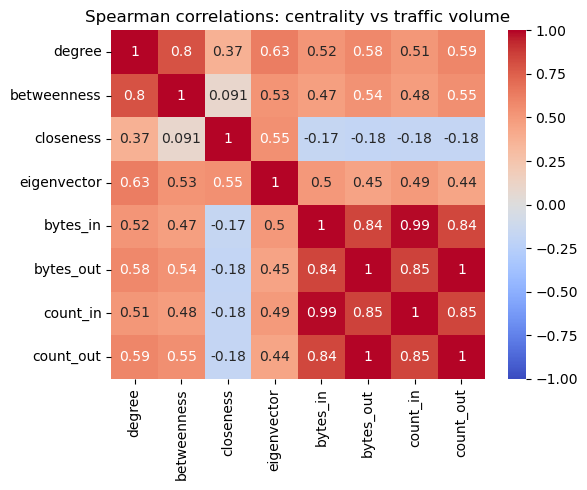

In [75]:
#Traffic volume insights
arel = pd.read_csv("output_ml_students/backend_assetrelationship.csv", usecols=['id','source_asset_id','target_asset_id']) ### Asset relationship file directory here ###
aser = pd.read_csv("output_ml_students/backend_assetrelationshipservice.csv", usecols=['relationship_id','bytes','count']) ### Asset relationship service file directory here ###

ser_rel = (aser.merge(arel, left_on='relationship_id', right_on='id', how='left').drop(columns=['id']))
out_traffic = (
    ser_rel.groupby('source_asset_id')[['bytes','count']]
           .sum()
           .reset_index()
           .rename(columns={'source_asset_id':'asset_id',
                            'bytes':'bytes_out', 'count':'count_out'}))
in_traffic = (
    ser_rel.groupby('target_asset_id')[['bytes','count']]
           .sum()
           .reset_index()
           .rename(columns={'target_asset_id':'asset_id',
                            'bytes':'bytes_in',  'count':'count_in'})
)

traffic = (
    out_traffic.merge(in_traffic, on='asset_id', how='outer')
               .fillna(0)
)

traffic = traffic.merge(asset['id'], left_on='asset_id', right_on='id', how='left')

df_corr = (
    c_log.merge(traffic[['id','bytes_out','bytes_in',
                          'count_out','count_in']],
                 left_on='name', right_on ='id', how='left')
          .fillna(0)
)
df_corr = df_corr.drop(columns = 'id')

cols_to_test = [
    'degree','betweenness','closeness','eigenvector',
    'bytes_in','bytes_out','count_in','count_out'
]
corr = df_corr[cols_to_test].corr(method='spearman')

plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Spearman correlations: centrality vs traffic volume")
plt.tight_layout();
plt.show()

